# 환율 예측 모델링

# 0. Library + Setting

In [3]:
import os, sys, gc, warnings, platform, random
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import platform
import tensorflow as tf
from collections import defaultdict
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# 환경 설정
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

# 재현성 고정
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# GPU 메모리 그로스 옵션
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
except Exception:
    pass

print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)

Python: 3.9.20 (main, Oct  3 2024, 07:38:01) [MSC v.1929 64 bit (AMD64)]
TensorFlow: 2.18.0
NumPy: 1.26.4
Pandas: 2.3.1


In [3]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  
mpl.rcParams['axes.unicode_minus'] = False

# EDA

In [1]:
def eda_basic_info(df, df_name="DataFrame"):
    print(f"\n===== {df_name} =====")
    print("Head (5 rows):")
    display(df.head())

    print("\nInfo:")
    print(df.info())

    print("\nDescribe (numeric):")
    display(df.describe())

    print("\nNull counts:")
    print(df.isnull().sum())

    print("="*40)

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

CSV_PATH   = "df_macro_with_sentiment_1010.csv"
df = pd.read_csv(CSV_PATH)
eda_basic_info(df, "df")


===== df =====
Head (5 rows):


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지,ksvkospi 종가,usd_jpy,usd_cny,us10y,copper,aluminum,vix,ovx,events_cnt,events_tone_mean,events_tone_kor_mean,gkg_doc_cnt,gkg_kr_loc_cnt,Direct_sentiment_mean,Direct_news_count,Indirect_sentiment_mean,Indirect_news_count,Combined_sentiment_mean,Combined_news_count
0,2020-01-02,1157.35,1155.02,2175.17,494680000.0,674.02,7.837300e+08,61.19,1528.94,28868.80,254290000.0,3257.8,944.3064,2935.6403,1.25,1.75,1.2,101.02,185.0,15.40,108.712997,6.9622,0.1882,2.8330,1812.50,12.47,28.750000,123425,-2.344266,-0.778714,75611,549,0.2000,10.0,0.0,1.0,0.1818,11.0
1,2020-01-03,1164.95,1157.95,2176.46,631560000.0,669.93,9.038600e+08,63.10,1551.65,28634.88,239590000.0,3234.8,944.3064,2935.6403,1.25,1.75,1.2,101.02,185.0,15.88,108.542999,6.9634,0.1788,2.7985,1830.00,14.02,31.920000,157403,-3.168823,-0.732867,83567,393,-0.1667,12.0,0.0,1.0,-0.1538,13.0
2,2020-01-06,1166.94,1165.89,2155.07,592670000.0,655.31,8.842800e+08,62.99,1565.96,28703.38,261810000.0,3246.3,944.3064,2935.6403,1.25,1.75,1.2,101.02,185.0,15.88,107.963997,6.9645,0.1811,2.8005,1842.00,13.85,32.320000,158919,-2.972238,-0.789447,87239,468,-0.6000,10.0,-1.0,2.0,-0.6667,12.0
3,2020-01-07,1167.30,1167.54,2175.54,568240000.0,663.44,9.703100e+08,64.92,1573.99,28583.68,266680000.0,3237.2,944.3064,2935.6403,1.25,1.75,1.2,101.02,185.0,15.08,108.405998,6.9745,0.1827,2.8040,1822.00,13.79,31.799999,179999,-2.862219,-0.597085,97851,549,-0.4000,10.0,0.0,4.0,-0.2857,14.0
4,2020-01-08,1162.25,1168.30,2151.31,913830000.0,640.94,1.380000e+09,59.97,1555.81,28745.09,296430000.0,3253.1,944.3064,2935.6403,1.25,1.75,1.2,101.02,185.0,15.97,108.015999,6.9444,0.1874,2.8190,1802.75,13.45,32.599998,197021,-2.913733,-0.965304,101503,478,-0.5000,10.0,-0.2,5.0,-0.4000,15.0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     1186 non-null   object 
 1   USD_KRW 종가               1186 non-null   float64
 2   USD_KRW 시가               1186 non-null   float64
 3   KOSPI 종가                 1186 non-null   float64
 4   KOSPI 거래량                1186 non-null   float64
 5   KOSDAQ 종가                1186 non-null   float64
 6   KOSDAQ 거래량               1186 non-null   float64
 7   WTI Price                1186 non-null   float64
 8   XAU Price                1186 non-null   float64
 9   DJI 종가                   1186 non-null   float64
 10  DJI 거래량                  1186 non-null   float64
 11  SP500 종가                 1186 non-null   float64
 12  M1                       1186 non-null   float64
 13  M2                       1186 non-null   float64
 14  한국 정책금리          

,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지,ksvkospi 종가,usd_jpy,usd_cny,us10y,copper,aluminum,vix,ovx,events_cnt,events_tone_mean,events_tone_kor_mean,gkg_doc_cnt,gkg_kr_loc_cnt,Direct_sentiment_mean,Direct_news_count,Indirect_sentiment_mean,Indirect_news_count,Combined_sentiment_mean,Combined_news_count
count,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1186.000000,1186.00000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000
mean,1256.282968,1256.633221,2596.073440,7.131867e+08,841.160118,1.306049e+09,69.533440,1937.514081,33603.138786,3.687432e+08,4250.179671,1219.394587,3616.388458,2.037789,2.60763,2.811298,111.501433,5333.790894,20.305084,127.855599,6.867263,0.267769,3.820936,2313.546796,21.438035,44.723179,133581.210793,-1.979816,-0.832832,88501.869309,617.335582,-0.070743,12.696459,-0.040528,3.875211,-0.068784,16.571669
std,93.743223,93.787299,339.282251,3.554851e+08,114.428855,5.210409e+08,23.291945,263.590609,4657.788950,1.128756e+08,764.021938,103.680673,347.336672,1.303587,2.31595,1.658261,7.401748,4255.906435,6.604767,18.424688,0.318528,0.139671,0.631159,420.719798,8.368224,24.293873,24788.607249,0.258274,0.832322,24450.602362,276.528215,0.429306,4.440581,0.367390,3.311090,0.351629,3.709767
min,1083.530000,1083.870000,1457.640000,8.245100e+05,428.350000,6.196200e+08,7.790000,1471.000000,18591.930000,1.170400e+08,2237.400000,944.306400,2935.640300,0.500000,0.25000,-0.200000,98.930000,-4205.000000,11.730000,102.678001,6.311500,0.049900,2.119500,1452.000000,11.860000,23.730000,0.000000,-3.333169,-3.924516,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000
25%,1181.822500,1182.460000,2399.310000,4.629025e+08,762.185000,9.524700e+08,62.090000,1778.307500,31022.087500,3.016050e+08,3810.150000,1184.088000,3309.121000,0.548387,0.25000,1.425000,103.890000,1862.000000,16.562500,109.376251,6.522125,0.141500,3.553000,2126.000000,15.855000,34.279999,117551.000000,-2.133663,-1.336452,68474.750000,435.000000,-0.363600,10.000000,-0.166700,1.000000,-0.298525,15.000000
50%,1265.610000,1266.325000,2568.480000,6.137650e+08,847.505000,1.170000e+09,73.735000,1870.390000,33913.620000,3.433250e+08,4200.010000,1221.110000,3718.332800,1.750000,1.75000,2.700000,116.270000,6365.000000,18.380000,130.802505,6.944150,0.291500,3.899500,2302.500000,19.629999,39.004999,133423.500000,-1.963814,-0.710838,85789.000000,547.000000,-0.074150,13.000000,0.000000,3.000000,-0.058800,18.000000
75%,1333.020000,1333.395000,2758.637500,8.662025e+08,919.412500,1.500000e+09,82.030000,1985.455000,35627.822500,4.021650e+08,4591.015000,1287.187300,3843.786700,3.500000,5.25000,3.800000,117.500000,7438.000000,22.415000,145.340996,7.145500,0.401000,4.288750,2534.125000,25.022501,47.485000,150155.000000,-1.832024,-0.234972,107725.000000,750.000000,0.207875,16.000000,0.000000,6.000000,0.150000,19.000000
max,1472.500000,1471.100000,3305.210000,3.460000e+09,1060.000000,5.070000e+09,126.470000,2786.190000,45014.040000,1.220000e+09,6090.270000,1371.920900,4183.535400,3.500000,5.50000,6.300000,119.560000,13096.000000,69.240000,161.606995,7.327800,0.498800,5.119000,3873.000000,82.690002,325.149994,216375.000000,0.000000,1.066490,157565.000000,3016.000000,1.000000,20.000000,1.000000,18.000000,1.000000,20.000000



Null counts:
date                       0
USD_KRW 종가                 0
USD_KRW 시가                 0
KOSPI 종가                   0
KOSPI 거래량                  0
KOSDAQ 종가                  0
KOSDAQ 거래량                 0
WTI Price                  0
XAU Price                  0
DJI 종가                     0
DJI 거래량                    0
SP500 종가                   0
M1                         0
M2                         0
한국 정책금리                    0
미국 정책금리                    0
CPI                        0
PPI                        0
경상수지                       0
ksvkospi 종가                0
usd_jpy                    0
usd_cny                    0
us10y                      0
copper                     0
aluminum                   0
vix                        0
ovx                        0
events_cnt                 0
events_tone_mean           0
events_tone_kor_mean       0
gkg_doc_cnt                0
gkg_kr_loc_cnt             0
Direct_sentiment_mean      0
Direct_news_count          0


In [6]:
def eda_basic_info2(df, df_name="DataFrame"):

    print("\nDescribe (numeric):")
    display(df.describe().T)  

eda_basic_info2(df, "df")


Describe (numeric):


,count,mean,std,min,25%,50%,75%,max
USD_KRW 종가,1186.0,1.256283e+03,9.374322e+01,1.083530e+03,1.181822e+03,1.265610e+03,1.333020e+03,1.472500e+03
USD_KRW 시가,1186.0,1.256633e+03,9.378730e+01,1.083870e+03,1.182460e+03,1.266325e+03,1.333395e+03,1.471100e+03
KOSPI 종가,1186.0,2.596073e+03,3.392823e+02,1.457640e+03,2.399310e+03,2.568480e+03,2.758637e+03,3.305210e+03
KOSPI 거래량,1186.0,7.131867e+08,3.554851e+08,8.245100e+05,4.629025e+08,6.137650e+08,8.662025e+08,3.460000e+09
KOSDAQ 종가,1186.0,8.411601e+02,1.144289e+02,4.283500e+02,7.621850e+02,8.475050e+02,9.194125e+02,1.060000e+03
KOSDAQ 거래량,1186.0,1.306049e+09,5.210409e+08,6.196200e+08,9.524700e+08,1.170000e+09,1.500000e+09,5.070000e+09
WTI Price,1186.0,6.953344e+01,2.329195e+01,7.790000e+00,6.209000e+01,7.373500e+01,8.203000e+01,1.264700e+02
XAU Price,1186.0,1.937514e+03,2.635906e+02,1.471000e+03,1.778307e+03,1.870390e+03,1.985455e+03,2.786190e+03
DJI 종가,1186.0,3.360314e+04,4.657789e+03,1.859193e+04,3.102209e+04,3.391362e+04,3.562782e+04,4.501404e+04
DJI 거래량,1186.0,3.687432e+08,1.128756e+08,1.170400e+08,3.016050e+08,3.433250e+08,4.021650e+08,1.220000e+09


# HitMap

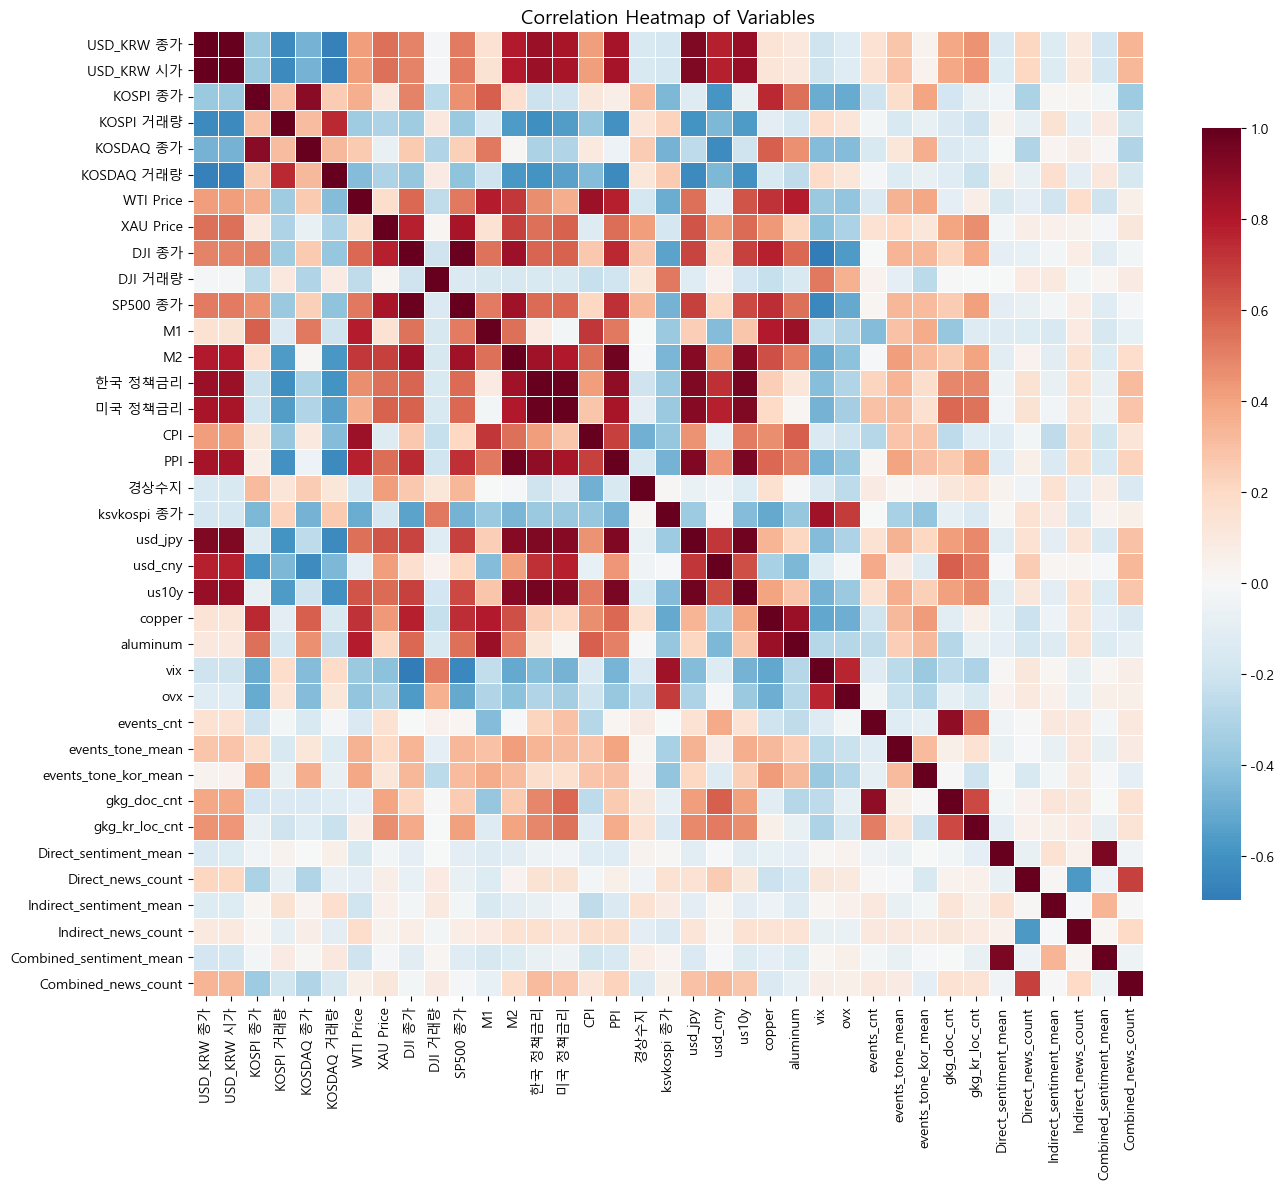

In [4]:
# 데이터 로드
CSV_PATH   = "df_macro_with_sentiment_1010.csv"
DATE_COL   = "date"
TARGET_COL = "USD_KRW 종가"

# Load dataset
df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

# 숫자형 변수만 선택 (타깃 포함)
num_df = df.select_dtypes(include=[np.number]).copy()

# news_count 제거
if "news_count" in num_df.columns:
    num_df = num_df.drop(columns=["news_count"])

# 결측치 제거
num_df = num_df.dropna()

# 상관관계 계산 (피어슨)
corr = num_df.corr(method="pearson")

# 히트맵 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(corr, cmap="RdBu_r", center=0, annot=False, fmt=".2f",
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation Heatmap of Variables", fontsize=14)
plt.tight_layout()
plt.show()

# ForeCasting

In [5]:
# =========================
# 설정
# =========================
CSV_PATH   = "df_macro_with_sentiment_1010.csv"   # 데이터 파일 경로
DATE_COL   = "date"                 # 날짜 컬럼명
TARGET_COL = "USD_KRW 종가"         # 타깃(환율 종가) 컬럼명

# 탐색 파라미터
LOOKBACK_LIST = [5, 10, 20, 30, 60, 90]
SHIFT_LIST    = [1]                 # 1=다음날 예측
EPOCHS        = 80
BATCH         = 64
SEEDS         = [42, 55, 68]        # 앙상블 평균용 시드

# DL 모델
MODEL_LIST    = ["LSTM", "GRU", "CNN_LSTM", "CNN_GRU"]

# 80/20 분할
TRAIN_RATIO = 0.8
VAL_RATIO   = 0.0

# 케이스(피처 조합)
CASES = [
    "Macro Only",         # Baseline 
    "Macro + Event",      # Baseline + GDELT
    "Macro + Sentiment",  # Baseline + Summary
    "ALL",                # Baseline + GDELT + Summary
]


# =========================
# GDELT / Sentiment 컬럼
# =========================
GDELT_COLS = [
    "events_cnt", "events_tone_mean", "events_tone_kor_mean",
    "gkg_doc_cnt", "gkg_kr_loc_cnt"
]

SENTIMENT_COLS = [
    "Direct_sentiment_mean", "Direct_news_count",
    "Indirect_sentiment_mean", "Indirect_news_count",
    "Combined_sentiment_mean", "Combined_news_count",
]

def get_summary_cols(df: pd.DataFrame):
    return [c for c in SENTIMENT_COLS if c in df.columns]

def get_all_senti_like_cols(df: pd.DataFrame):
    senti = set(get_summary_cols(df))
    evts  = set([c for c in GDELT_COLS if c in df.columns])
    return list(senti | evts)

In [6]:
# =========================
# 공통 유틸 
# =========================
def eval_metrics(y_true, y_pred, eps=1e-8):
    """
    반환:
      - 원 단위: MSE, RMSE, MAE, MedAE
      - %  단위: MAPE, MSPE, MedAPE
    """
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)

    denom = np.maximum(np.abs(y_true), eps)
    ape   = np.abs(y_true - y_pred) / denom
    spe   = ((y_true - y_pred) / denom) ** 2

    mape   = np.mean(ape) * 100.0
    mspe   = np.mean(spe) * 100.0
    medae  = np.median(np.abs(y_true - y_pred))
    medape = np.median(ape) * 100.0

    return dict(
        MSE=mse, RMSE=rmse, MAE=mae, MAPE=mape,
        MSPE=mspe, MedAE=medae, MedAPE=medape
    )

def split_indices(n, tr_ratio=0.8, va_ratio=0.0):
    n_test = int(n * (1 - tr_ratio - va_ratio))
    n_val  = int(n * va_ratio)
    n_tr   = n - n_val - n_test
    return slice(0, n_tr), slice(n_tr, n_tr+n_val), slice(n_tr+n_val, n)

def make_sequences_residual(X, y, lookback, shift=1):
    """
    Δ-타깃 학습(잔차 예측):
      y_d = y[target] - y[target-1]
      최종 예측 = p_last + d_pred
    """
    X_seq, y_d, p_last, y_true = [], [], [], []
    n = len(y)
    max_i = n - lookback - shift
    for i in range(max_i):
        idx_last   = i + lookback - 1
        target_idx = idx_last + shift
        prev_idx   = target_idx - 1
        X_seq.append(X[i:i+lookback])
        y_d.append(y[target_idx] - y[prev_idx])
        p_last.append(y[prev_idx])
        y_true.append(y[target_idx])
    return (np.array(X_seq, np.float32),
            np.array(y_d,   np.float32),
            np.array(p_last, np.float32),
            np.array(y_true, np.float32))

def make_sequences_residual_with_dates(X, y, dates, lookback, shift=1):
    X_seq, y_d, p_last, y_true, d_targets = [], [], [], [], []
    n = len(y)
    max_i = n - lookback - shift
    for i in range(max_i):
        idx_last   = i + lookback - 1
        target_idx = idx_last + shift
        prev_idx   = target_idx - 1
        X_seq.append(X[i:i+lookback])
        y_d.append(y[target_idx] - y[prev_idx])
        p_last.append(y[prev_idx])
        y_true.append(y[target_idx])
        d_targets.append(dates[target_idx])
    return (np.array(X_seq, np.float32),
            np.array(y_d,   np.float32),
            np.array(p_last, np.float32),
            np.array(y_true, np.float32),
            np.array(d_targets))

In [7]:
# =========================
# 모델 정의
# =========================
def build_lstm(input_shape):
    m = Sequential([
        Input(shape=input_shape),
        LSTM(64, return_sequences=True), Dropout(0.1),
        LSTM(32), Dropout(0.1),
        Dense(1)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m

def build_gru(input_shape):
    m = Sequential([
        Input(shape=input_shape),
        GRU(64, return_sequences=True), Dropout(0.1),
        GRU(32), Dropout(0.1),
        Dense(1)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m

def build_cnn_lstm(input_shape):
    m = Sequential([
        Input(shape=input_shape),
        Conv1D(64, kernel_size=3, padding="causal", activation="relu"),
        BatchNormalization(), Dropout(0.1),
        Conv1D(64, kernel_size=3, padding="causal", activation="relu"),
        BatchNormalization(), Dropout(0.1),
        LSTM(64, return_sequences=True), Dropout(0.1),
        LSTM(32), Dropout(0.1),
        Dense(1)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m

def build_cnn_gru(input_shape):
    m = Sequential([
        Input(shape=input_shape),
        Conv1D(64, kernel_size=3, padding="causal", activation="relu"),
        BatchNormalization(), Dropout(0.1),
        Conv1D(64, kernel_size=3, padding="causal", activation="relu"),
        BatchNormalization(), Dropout(0.1),
        GRU(64, return_sequences=True), Dropout(0.1),
        GRU(32), Dropout(0.1),
        Dense(1)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m

def build_model(name, input_shape):
    u = name.upper()
    if u == "LSTM":      return build_lstm(input_shape)
    if u == "GRU":       return build_gru(input_shape)
    if u == "CNN_LSTM":  return build_cnn_lstm(input_shape)
    if u == "CNN_GRU":   return build_cnn_gru(input_shape)
    raise ValueError(f"Unknown model: {name}")

In [8]:
# =========================
# 데이터 로드
# =========================
assert os.path.exists(CSV_PATH), f"CSV 파일을 찾을 수 없습니다: {CSV_PATH}"

df_raw = (pd.read_csv(CSV_PATH, encoding="utf-8-sig")
            .replace([np.inf, -np.inf], np.nan))
df_raw[DATE_COL] = pd.to_datetime(df_raw[DATE_COL], errors="coerce")
df_raw = df_raw.sort_values(DATE_COL).dropna(subset=[DATE_COL, TARGET_COL]).reset_index(drop=True)

print("df_raw.shape:", df_raw.shape)
print("기간:", df_raw[DATE_COL].min(), "~", df_raw[DATE_COL].max())
print("컬럼 샘플:", list(df_raw.columns)[:10])
df_raw.head(3)

df_raw.shape: (1186, 38)
기간: 2020-01-02 00:00:00 ~ 2024-12-30 00:00:00
컬럼 샘플: ['date', 'USD_KRW 종가', 'USD_KRW 시가', 'KOSPI 종가', 'KOSPI 거래량', 'KOSDAQ 종가', 'KOSDAQ 거래량', 'WTI Price', 'XAU Price', 'DJI 종가']


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,...,events_tone_mean,events_tone_kor_mean,gkg_doc_cnt,gkg_kr_loc_cnt,Direct_sentiment_mean,Direct_news_count,Indirect_sentiment_mean,Indirect_news_count,Combined_sentiment_mean,Combined_news_count
0,2020-01-02,1157.35,1155.02,2175.17,494680000.0,674.02,783730000.0,61.19,1528.94,28868.80,...,-2.344266,-0.778714,75611,549,0.2000,10.0,0.0,1.0,0.1818,11.0
1,2020-01-03,1164.95,1157.95,2176.46,631560000.0,669.93,903860000.0,63.10,1551.65,28634.88,...,-3.168823,-0.732867,83567,393,-0.1667,12.0,0.0,1.0,-0.1538,13.0
2,2020-01-06,1166.94,1165.89,2155.07,592670000.0,655.31,884280000.0,62.99,1565.96,28703.38,...,-2.972238,-0.789447,87239,468,-0.6000,10.0,-1.0,2.0,-0.6667,12.0


In [10]:
def build_case_df(case_name: str):
    # 베이스: 감정/뉴스/GDELT 제거
    all_senti_cols = get_all_senti_like_cols(df_raw)              # 감정 + GDELT (존재 컬럼만)
    df_base = df_raw.drop(columns=all_senti_cols, errors="ignore").copy()
    numeric_cols_base = [c for c in df_base.select_dtypes(include=[np.number]).columns if c != TARGET_COL]

    if case_name == "Macro Only":
        # 인덱스 기반 드롭 대신, 매크로 수치 피처만 사용
        keep = [DATE_COL, TARGET_COL] + numeric_cols_base
        df_case = df_raw[keep].copy()
        return (df_case.dropna().sort_values(DATE_COL).reset_index(drop=True))

    elif case_name == "Macro + Event":
        gdelt_present = [c for c in GDELT_COLS if c in df_raw.columns]
        keep = [DATE_COL, TARGET_COL] + numeric_cols_base + gdelt_present
        return (df_raw[keep].dropna().sort_values(DATE_COL).reset_index(drop=True))

    elif case_name == "Macro + Sentiment":
        summary_cols = [c for c in get_summary_cols(df_raw) if c in df_raw.columns]  # SENTIMENT_COLS 기반
        keep = [DATE_COL, TARGET_COL] + numeric_cols_base + summary_cols
        return (df_raw[keep].dropna().sort_values(DATE_COL).reset_index(drop=True))

    elif case_name == "ALL":
        gdelt_present  = [c for c in GDELT_COLS if c in df_raw.columns]
        summary_cols   = [c for c in get_summary_cols(df_raw) if c in df_raw.columns]
        keep = [DATE_COL, TARGET_COL] + numeric_cols_base + gdelt_present + summary_cols
        return (df_raw[keep].dropna().sort_values(DATE_COL).reset_index(drop=True))

    else:
        raise ValueError(f"Unknown case: {case_name}")


In [11]:
# =========================
# 러너
# =========================
def run_once(df_case, model_name="LSTM", seed=42, lookback=5, shift=1):
    set_seed(seed)

    feats = [c for c in df_case.select_dtypes(include=[np.number]).columns if c != TARGET_COL]
    X_all = df_case[feats].values.astype(np.float32)
    y_all = df_case[TARGET_COL].values.astype(np.float32)

    s_tr, s_va, s_te = split_indices(len(df_case), tr_ratio=TRAIN_RATIO, va_ratio=VAL_RATIO)
    X_tr_raw = X_all[s_tr]; X_te_raw = X_all[s_te]
    y_tr_raw = y_all[s_tr]; y_te_raw = y_all[s_te]

    # 입력 스케일러 (train fit)
    x_scaler = RobustScaler()
    X_tr = x_scaler.fit_transform(X_tr_raw)
    X_te = x_scaler.transform(X_te_raw)

    # Δ-타깃 스케일러 (train seq 기반 fit)
    X_tr_seq_tmp, y_d_tr_raw, _, _ = make_sequences_residual(X_tr, y_tr_raw, lookback, shift=shift)
    if len(X_tr_seq_tmp) == 0:
        raise ValueError("시퀀스 길이 부족")
    d_scaler = RobustScaler()
    y_d_tr_sc = d_scaler.fit_transform(y_d_tr_raw.reshape(-1,1)).ravel()

    # 내부 val 분리(훈련 시퀀스 10%)
    n_tr_seq = len(X_tr_seq_tmp)
    val_sz = max(1, int(n_tr_seq*0.1))
    X_train, y_train = X_tr_seq_tmp[:-val_sz], y_d_tr_sc[:-val_sz]
    X_valin, y_valin = X_tr_seq_tmp[-val_sz:],  y_d_tr_sc[-val_sz:]

    # 테스트 시퀀스
    X_te_seq, y_d_te_raw, p_last_te_raw, y_true_te_raw = make_sequences_residual(X_te, y_te_raw, lookback, shift=shift)
    if len(X_te_seq) == 0:
        raise ValueError("시퀀스 길이 부족(테스트)")

    cbs = [
        EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=0),
    ]

    model = build_model(model_name, (lookback, X_train.shape[-1]))
    model.fit(X_train, y_train, validation_data=(X_valin, y_valin),
              epochs=EPOCHS, batch_size=BATCH, callbacks=cbs, verbose=0)

    d_pred_sc = model.predict(X_te_seq, verbose=0).ravel()
    d_pred = d_scaler.inverse_transform(d_pred_sc.reshape(-1,1)).ravel()
    yhat = p_last_te_raw + d_pred

    return eval_metrics(y_true_te_raw, yhat)

In [12]:
def run_all(cases, models, seeds, shifts, lookbacks):
    rows = []
    for case in cases:
        df_case = build_case_df(case)
        for lb in lookbacks:
            for mdl in models:
                for sh in shifts:
                    for sd in seeds:
                        m = run_once(df_case, model_name=mdl, seed=sd, lookback=lb, shift=sh)
                        rows.append([case, lb, mdl, sh, sd,
                                     m["MSE"], m["RMSE"], m["MAE"], m["MAPE"],
                                     m["MSPE"], m["MedAE"], m["MedAPE"]])
    res_cols = ["case","lookback","model","shift","seed",
                "MSE","RMSE","MAE","MAPE","MSPE","MedAE","MedAPE"]
    return pd.DataFrame(rows, columns=res_cols)

In [13]:
# === 모델×케이스 표 ===
CASE_LABEL = {
    "Macro Only":       "Macro Only",
    "Macro + Event":         "Macro + Event",
    "Macro + Sentiment":       "Macro + Sentiment",
    "ALL": "ALL",
}
CASE_ORDER = ["Macro Only", "Macro + Event", "Macro + Sentiment", "ALL"]
METRICS = ["RMSE", "MAE", "MAPE", "MedAE", "MedAPE"]

def make_model_case_tables(res_df, lookbacks, shift=None, digits=3, save_csv=True):
    if shift is None:
        shift_vals = sorted(res_df["shift"].unique())
        shift = shift_vals[0] if len(shift_vals) else 1

    # 케이스 라벨 컬럼 추가
    tmp = res_df.copy()
    tmp["케이스"] = tmp["case"].map(CASE_LABEL).fillna(tmp["case"])

    for lb in lookbacks:
        sub = tmp[(tmp["lookback"] == lb) & (tmp["shift"] == shift)]
        if sub.empty:
            print(f"\n=== LookBack : {lb} (shift={shift}) ===\n데이터가 없습니다.")
            continue

        # 시드 평균 집계
        agg = (sub.groupby(["model", "케이스"], as_index=False)
                  .agg({m: "mean" for m in METRICS}))

        # 정렬: MODEL_LIST 순서, 케이스 지정 순서
        agg["model_order"]  = agg["model"].apply(lambda x: MODEL_LIST.index(x) if x in MODEL_LIST else 999)
        agg["case_order"]   = agg["케이스"].apply(lambda x: CASE_ORDER.index(x) if x in CASE_ORDER else 999)
        agg = agg.sort_values(["model_order","case_order"]).drop(columns=["model_order","case_order"])

        # 표시용 포맷
        for m in METRICS:
            agg[m] = agg[m].apply(lambda v: ("" if pd.isna(v) else f"{v:.{digits}f}"))

        # 출력 테이블
        tbl = agg.rename(columns={"model":"Model"})[["Model","케이스"] + METRICS]

        print(f"\n=== LookBack : {lb} ===")
        try:
            from IPython.display import display
            display(tbl)
        except Exception:
            print(tbl.to_string(index=False))

# 실행 
res = run_all(CASES, MODEL_LIST, SEEDS, SHIFT_LIST, LOOKBACK_LIST)
make_model_case_tables(res, LOOKBACK_LIST, shift=(SHIFT_LIST[0] if len(SHIFT_LIST) else None))


=== LookBack : 5 ===


,Model,케이스,RMSE,MAE,MAPE,MedAE,MedAPE
15,LSTM,Macro Only,7.229,5.557,0.407,4.609,0.341
13,LSTM,Macro + Event,7.316,5.619,0.412,4.606,0.340
14,LSTM,Macro + Sentiment,7.183,5.521,0.405,4.623,0.343
12,LSTM,ALL,7.317,5.645,0.414,4.660,0.337
11,GRU,Macro Only,7.376,5.676,0.416,4.580,0.337
9,GRU,Macro + Event,7.552,5.816,0.426,4.749,0.346
10,GRU,Macro + Sentiment,7.566,5.852,0.428,4.755,0.350
8,GRU,ALL,7.670,5.929,0.434,4.782,0.352
7,CNN_LSTM,Macro Only,7.403,5.625,0.413,4.609,0.339
5,CNN_LSTM,Macro + Event,7.162,5.440,0.399,4.549,0.336



=== LookBack : 10 ===


,Model,케이스,RMSE,MAE,MAPE,MedAE,MedAPE
15,LSTM,Macro Only,7.089,5.468,0.401,4.665,0.343
13,LSTM,Macro + Event,7.110,5.479,0.401,4.569,0.332
14,LSTM,Macro + Sentiment,7.124,5.511,0.404,4.684,0.347
12,LSTM,ALL,7.103,5.497,0.403,4.628,0.344
11,GRU,Macro Only,7.739,6.055,0.442,4.802,0.352
9,GRU,Macro + Event,7.596,5.917,0.432,4.707,0.348
10,GRU,Macro + Sentiment,7.595,5.924,0.433,4.870,0.355
8,GRU,ALL,7.560,5.869,0.429,4.812,0.354
7,CNN_LSTM,Macro Only,7.254,5.586,0.409,4.716,0.345
5,CNN_LSTM,Macro + Event,7.400,5.650,0.414,4.716,0.345



=== LookBack : 20 ===


,Model,케이스,RMSE,MAE,MAPE,MedAE,MedAPE
15,LSTM,Macro Only,7.094,5.560,0.407,4.654,0.341
13,LSTM,Macro + Event,6.946,5.384,0.394,4.562,0.333
14,LSTM,Macro + Sentiment,7.053,5.533,0.405,4.663,0.341
12,LSTM,ALL,7.086,5.567,0.407,4.652,0.341
11,GRU,Macro Only,7.000,5.424,0.397,4.585,0.337
9,GRU,Macro + Event,7.303,5.692,0.416,4.819,0.354
10,GRU,Macro + Sentiment,7.375,5.767,0.421,4.761,0.346
8,GRU,ALL,7.376,5.717,0.418,4.799,0.351
7,CNN_LSTM,Macro Only,7.101,5.483,0.401,4.484,0.329
5,CNN_LSTM,Macro + Event,7.173,5.557,0.407,4.611,0.338



=== LookBack : 30 ===


,Model,케이스,RMSE,MAE,MAPE,MedAE,MedAPE
15,LSTM,Macro Only,7.122,5.523,0.404,4.536,0.333
13,LSTM,Macro + Event,7.002,5.363,0.392,4.441,0.321
14,LSTM,Macro + Sentiment,7.146,5.593,0.409,4.660,0.341
12,LSTM,ALL,7.116,5.565,0.406,4.666,0.344
11,GRU,Macro Only,7.598,5.985,0.436,4.801,0.352
9,GRU,Macro + Event,7.483,5.841,0.426,4.809,0.352
10,GRU,Macro + Sentiment,7.642,6.047,0.441,4.991,0.363
8,GRU,ALL,7.569,5.979,0.436,4.833,0.354
7,CNN_LSTM,Macro Only,7.052,5.426,0.397,4.533,0.331
5,CNN_LSTM,Macro + Event,7.098,5.411,0.396,4.366,0.317



=== LookBack : 60 ===


,Model,케이스,RMSE,MAE,MAPE,MedAE,MedAPE
15,LSTM,Macro Only,7.342,5.623,0.410,4.476,0.326
13,LSTM,Macro + Event,7.339,5.574,0.406,4.404,0.317
14,LSTM,Macro + Sentiment,7.367,5.673,0.413,4.580,0.334
12,LSTM,ALL,7.244,5.555,0.405,4.491,0.325
11,GRU,Macro Only,7.927,6.097,0.444,5.039,0.368
9,GRU,Macro + Event,7.849,6.050,0.440,5.010,0.366
10,GRU,Macro + Sentiment,7.581,5.900,0.429,4.756,0.343
8,GRU,ALL,8.172,6.380,0.464,5.300,0.387
7,CNN_LSTM,Macro Only,7.276,5.579,0.406,4.468,0.327
5,CNN_LSTM,Macro + Event,7.429,5.640,0.411,4.743,0.343



=== LookBack : 90 ===


,Model,케이스,RMSE,MAE,MAPE,MedAE,MedAPE
15,LSTM,Macro Only,7.261,5.535,0.403,4.522,0.329
13,LSTM,Macro + Event,7.281,5.544,0.404,4.358,0.316
14,LSTM,Macro + Sentiment,7.294,5.592,0.407,4.590,0.333
12,LSTM,ALL,7.238,5.548,0.404,4.451,0.326
11,GRU,Macro Only,7.665,5.868,0.426,4.768,0.345
9,GRU,Macro + Event,7.803,5.996,0.436,4.956,0.364
10,GRU,Macro + Sentiment,7.789,6.052,0.439,4.905,0.359
8,GRU,ALL,7.709,5.951,0.433,4.921,0.356
7,CNN_LSTM,Macro Only,7.382,5.644,0.411,4.638,0.338
5,CNN_LSTM,Macro + Event,7.392,5.640,0.410,4.427,0.323


In [14]:
# 케이스 라벨
CASE_LABEL = {
    "ExcludePos24_47":       "Macro Only",
    "Include_GDELT":         "Macro + Event",
    "Include_Summary":       "Macro + Sentiment",
    "Include_GDELT_Summary": "ALL",
}
CASE_ORDER  = ["Macro Only", "Macro + Event", "Macro + Sentiment", "ALL"]
METRICS_MC  = ["RMSE", "MAE", "MAPE", "MedAE", "MedAPE"]   # 모델×케이스 표에 표시할 지표
FMT_DIGITS  = 3

def _pick_shift(df, shift=None):
    if shift is not None:
        return shift
    sh_list = sorted(df["shift"].unique())
    return sh_list[0] if len(sh_list) else 1

def show_model_case_tables(res_df, lookbacks, shift=None, digits=FMT_DIGITS):
    """표 1) 룩백별: 행=Model×케이스, 열=RMSE/MAE/MAPE/MedAE/MedAPE"""
    sh = _pick_shift(res_df, shift)
    tmp = res_df[res_df["shift"] == sh].copy()
    tmp["케이스"] = tmp["case"].map(CASE_LABEL).fillna(tmp["case"])

    for lb in lookbacks:
        sub = tmp[tmp["lookback"] == lb]
        if sub.empty:
            print(f"\n=== LookBack : {lb} (shift={sh}) ===")
            print("데이터가 없습니다.")
            continue

        # 시드 평균 집계
        agg = (sub.groupby(["model","케이스"], as_index=False)
                  .agg({m: "mean" for m in METRICS_MC}))

        # 정렬: 모델 지정 순서, 케이스 지정 순서
        agg["model_order"] = agg["model"].apply(lambda x: MODEL_LIST.index(x) if x in MODEL_LIST else 999)
        agg["case_order"]  = agg["케이스"].apply(lambda x: CASE_ORDER.index(x) if x in CASE_ORDER else 999)
        agg = agg.sort_values(["model_order","case_order"]).drop(columns=["model_order","case_order"])

        # 포맷
        for m in METRICS_MC:
            agg[m] = agg[m].apply(lambda v: "" if pd.isna(v) else f"{v:.{digits}f}")

        tbl = agg.rename(columns={"model":"Model"})[["Model","케이스"] + METRICS_MC]

        print(f"\n=== LookBack : {lb} ===")
        try:
            from IPython.display import display
            display(tbl)
        except Exception:
            print(tbl.to_string(index=False))

def show_best_lookback_tables(res_df, metric="RMSE", shift=None, digits=FMT_DIGITS):
    """표 2) (a) 전역 Lookback 평균 성능 (모델×케이스 평균)  (b) Model×케이스별 Best Lookback"""
    assert metric in ["MSE","RMSE","MAE","MAPE","MSPE","MedAE","MedAPE"]
    sh = _pick_shift(res_df, shift)

    # 시드 평균 -> (case, model, lookback, shift) 단위
    g = (res_df[res_df["shift"] == sh]
            .groupby(["case","model","lookback","shift"], as_index=False)
            .agg({
                "MSE":"mean","RMSE":"mean","MAE":"mean","MAPE":"mean",
                "MSPE":"mean","MedAE":"mean","MedAPE":"mean"
            }))

    # (a) 전역 Lookback 평균 성능
    overall = (g.groupby("lookback", as_index=False)
                 .agg({"RMSE":"mean","MAE":"mean","MAPE":"mean","MedAE":"mean","MedAPE":"mean","MSE":"mean","MSPE":"mean"}))
    overall = overall.sort_values("RMSE", ascending=True).reset_index(drop=True)
    overall["Rank(RMSE)"] = np.arange(1, len(overall)+1)

    for c in ["MSE","RMSE","MAE","MAPE","MSPE","MedAE","MedAPE"]:
        overall[c] = overall[c].apply(lambda v: f"{v:.{digits}f}")

    print(f"\n=== [Overall] Lookback별 평균 성능 (shift={sh}, 모든 모델×케이스 평균, RMSE 오름차순) ===")
    try:
        from IPython.display import display
        display(overall[["Rank(RMSE)","lookback","RMSE","MAE","MAPE","MedAE","MedAPE","MSE","MSPE"]])
    except Exception:
        print(overall.to_string(index=False))

    # (b) Model×케이스별 Best Lookback (metric 기준 최솟값, 동률 시 더 작은 lookback)
    gg = g.copy()
    gg["케이스"] = gg["case"].map(CASE_LABEL).fillna(gg["case"])
    gg = gg.sort_values(["model","케이스", metric, "lookback"], ascending=[True, True, True, True])
    best = gg.groupby(["model","케이스"], as_index=False).first()

    best["model_order"] = best["model"].apply(lambda x: MODEL_LIST.index(x) if x in MODEL_LIST else 999)
    best["case_order"]  = best["케이스"].apply(lambda x: CASE_ORDER.index(x) if x in CASE_ORDER else 999)
    best = best.sort_values(["model_order","case_order"]).drop(columns=["model_order","case_order"])

    best_tbl = (best[["model","케이스","lookback","RMSE","MAE","MAPE","MedAE","MedAPE"]]
                .rename(columns={"model":"Model","lookback":"Best Lookback"}))

    for c in ["RMSE","MAE","MAPE","MedAE","MedAPE"]:
        best_tbl[c] = best_tbl[c].apply(lambda v: f"{v:.{digits}f}")

    print(f"\n=== [Per Model × 케이스] metric={metric} 기준 Best Lookback (shift={sh}) ===")
    try:
        from IPython.display import display
        display(best_tbl)
    except Exception:
        print(best_tbl.to_string(index=False))

# ==== 실행 ====
# 1) 룩백별 Model×케이스 요약표
show_model_case_tables(res, LOOKBACK_LIST, shift=(SHIFT_LIST[0] if len(SHIFT_LIST) else None))

# 2) Lookback 베스트 표 (전역 + Model×케이스별)
show_best_lookback_tables(res, metric="RMSE", shift=(SHIFT_LIST[0] if len(SHIFT_LIST) else None))


=== LookBack : 5 ===


,Model,케이스,RMSE,MAE,MAPE,MedAE,MedAPE
15,LSTM,Macro Only,7.229,5.557,0.407,4.609,0.341
13,LSTM,Macro + Event,7.316,5.619,0.412,4.606,0.340
14,LSTM,Macro + Sentiment,7.183,5.521,0.405,4.623,0.343
12,LSTM,ALL,7.317,5.645,0.414,4.660,0.337
11,GRU,Macro Only,7.376,5.676,0.416,4.580,0.337
9,GRU,Macro + Event,7.552,5.816,0.426,4.749,0.346
10,GRU,Macro + Sentiment,7.566,5.852,0.428,4.755,0.350
8,GRU,ALL,7.670,5.929,0.434,4.782,0.352
7,CNN_LSTM,Macro Only,7.403,5.625,0.413,4.609,0.339
5,CNN_LSTM,Macro + Event,7.162,5.440,0.399,4.549,0.336



=== LookBack : 10 ===


,Model,케이스,RMSE,MAE,MAPE,MedAE,MedAPE
15,LSTM,Macro Only,7.089,5.468,0.401,4.665,0.343
13,LSTM,Macro + Event,7.110,5.479,0.401,4.569,0.332
14,LSTM,Macro + Sentiment,7.124,5.511,0.404,4.684,0.347
12,LSTM,ALL,7.103,5.497,0.403,4.628,0.344
11,GRU,Macro Only,7.739,6.055,0.442,4.802,0.352
9,GRU,Macro + Event,7.596,5.917,0.432,4.707,0.348
10,GRU,Macro + Sentiment,7.595,5.924,0.433,4.870,0.355
8,GRU,ALL,7.560,5.869,0.429,4.812,0.354
7,CNN_LSTM,Macro Only,7.254,5.586,0.409,4.716,0.345
5,CNN_LSTM,Macro + Event,7.400,5.650,0.414,4.716,0.345



=== LookBack : 20 ===


,Model,케이스,RMSE,MAE,MAPE,MedAE,MedAPE
15,LSTM,Macro Only,7.094,5.560,0.407,4.654,0.341
13,LSTM,Macro + Event,6.946,5.384,0.394,4.562,0.333
14,LSTM,Macro + Sentiment,7.053,5.533,0.405,4.663,0.341
12,LSTM,ALL,7.086,5.567,0.407,4.652,0.341
11,GRU,Macro Only,7.000,5.424,0.397,4.585,0.337
9,GRU,Macro + Event,7.303,5.692,0.416,4.819,0.354
10,GRU,Macro + Sentiment,7.375,5.767,0.421,4.761,0.346
8,GRU,ALL,7.376,5.717,0.418,4.799,0.351
7,CNN_LSTM,Macro Only,7.101,5.483,0.401,4.484,0.329
5,CNN_LSTM,Macro + Event,7.173,5.557,0.407,4.611,0.338



=== LookBack : 30 ===


,Model,케이스,RMSE,MAE,MAPE,MedAE,MedAPE
15,LSTM,Macro Only,7.122,5.523,0.404,4.536,0.333
13,LSTM,Macro + Event,7.002,5.363,0.392,4.441,0.321
14,LSTM,Macro + Sentiment,7.146,5.593,0.409,4.660,0.341
12,LSTM,ALL,7.116,5.565,0.406,4.666,0.344
11,GRU,Macro Only,7.598,5.985,0.436,4.801,0.352
9,GRU,Macro + Event,7.483,5.841,0.426,4.809,0.352
10,GRU,Macro + Sentiment,7.642,6.047,0.441,4.991,0.363
8,GRU,ALL,7.569,5.979,0.436,4.833,0.354
7,CNN_LSTM,Macro Only,7.052,5.426,0.397,4.533,0.331
5,CNN_LSTM,Macro + Event,7.098,5.411,0.396,4.366,0.317



=== LookBack : 60 ===


,Model,케이스,RMSE,MAE,MAPE,MedAE,MedAPE
15,LSTM,Macro Only,7.342,5.623,0.410,4.476,0.326
13,LSTM,Macro + Event,7.339,5.574,0.406,4.404,0.317
14,LSTM,Macro + Sentiment,7.367,5.673,0.413,4.580,0.334
12,LSTM,ALL,7.244,5.555,0.405,4.491,0.325
11,GRU,Macro Only,7.927,6.097,0.444,5.039,0.368
9,GRU,Macro + Event,7.849,6.050,0.440,5.010,0.366
10,GRU,Macro + Sentiment,7.581,5.900,0.429,4.756,0.343
8,GRU,ALL,8.172,6.380,0.464,5.300,0.387
7,CNN_LSTM,Macro Only,7.276,5.579,0.406,4.468,0.327
5,CNN_LSTM,Macro + Event,7.429,5.640,0.411,4.743,0.343



=== LookBack : 90 ===


,Model,케이스,RMSE,MAE,MAPE,MedAE,MedAPE
15,LSTM,Macro Only,7.261,5.535,0.403,4.522,0.329
13,LSTM,Macro + Event,7.281,5.544,0.404,4.358,0.316
14,LSTM,Macro + Sentiment,7.294,5.592,0.407,4.590,0.333
12,LSTM,ALL,7.238,5.548,0.404,4.451,0.326
11,GRU,Macro Only,7.665,5.868,0.426,4.768,0.345
9,GRU,Macro + Event,7.803,5.996,0.436,4.956,0.364
10,GRU,Macro + Sentiment,7.789,6.052,0.439,4.905,0.359
8,GRU,ALL,7.709,5.951,0.433,4.921,0.356
7,CNN_LSTM,Macro Only,7.382,5.644,0.411,4.638,0.338
5,CNN_LSTM,Macro + Event,7.392,5.640,0.410,4.427,0.323



=== [Overall] Lookback별 평균 성능 (shift=1, 모든 모델×케이스 평균, RMSE 오름차순) ===


,Rank(RMSE),lookback,RMSE,MAE,MAPE,MedAE,MedAPE,MSE,MSPE
0,1,20,7.132,5.542,0.405,4.627,0.339,50.930,0.003
1,2,10,7.281,5.611,0.411,4.682,0.344,53.084,0.003
2,3,30,7.287,5.654,0.413,4.654,0.340,53.210,0.003
3,4,5,7.331,5.617,0.412,4.615,0.340,53.788,0.003
4,5,90,7.458,5.714,0.416,4.654,0.339,55.716,0.003
5,6,60,7.516,5.774,0.420,4.707,0.342,56.623,0.003



=== [Per Model × 케이스] metric=RMSE 기준 Best Lookback (shift=1) ===


,Model,케이스,Best Lookback,RMSE,MAE,MAPE,MedAE,MedAPE
15,LSTM,Macro Only,10,7.089,5.468,0.401,4.665,0.343
13,LSTM,Macro + Event,20,6.946,5.384,0.394,4.562,0.333
14,LSTM,Macro + Sentiment,20,7.053,5.533,0.405,4.663,0.341
12,LSTM,ALL,20,7.086,5.567,0.407,4.652,0.341
11,GRU,Macro Only,20,7.000,5.424,0.397,4.585,0.337
9,GRU,Macro + Event,20,7.303,5.692,0.416,4.819,0.354
10,GRU,Macro + Sentiment,20,7.375,5.767,0.421,4.761,0.346
8,GRU,ALL,20,7.376,5.717,0.418,4.799,0.351
7,CNN_LSTM,Macro Only,30,7.052,5.426,0.397,4.533,0.331
5,CNN_LSTM,Macro + Event,30,7.098,5.411,0.396,4.366,0.317


# Permutation Importance


=== Primary Setting ===
Case=Macro + Event, Model=LSTM, lookback=20, shift=1, seed=42
Baseline Test MSE=48.548, RMSE=6.968

=== Permutation Importance (ΔMSE) — Top 20 ===


,feature,importance(ΔMSE),group
0,SP500 종가,0.396938,Macro/Market
1,경상수지,0.348356,Macro/Market
2,DJI 종가,0.280941,Macro/Market
3,events_tone_mean,0.229335,Event(GDELT)
4,CPI,0.121022,Macro/Market
5,WTI Price,0.080845,Macro/Market
6,KOSDAQ 종가,0.077296,Macro/Market
7,M2,0.065762,Macro/Market
8,copper,0.064516,Macro/Market
9,KOSDAQ 거래량,0.047183,Macro/Market



=== Group-wise Importance (sum of ΔMSE) ===


,group,importance(ΔMSE)
0,Macro/Market,0.255025
1,Event(GDELT),0.028620


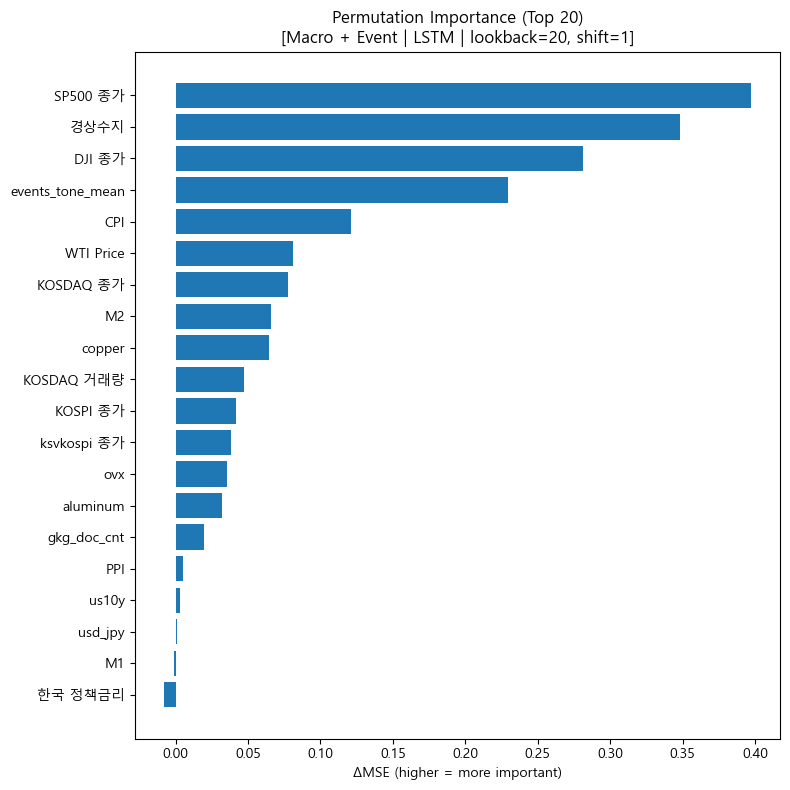

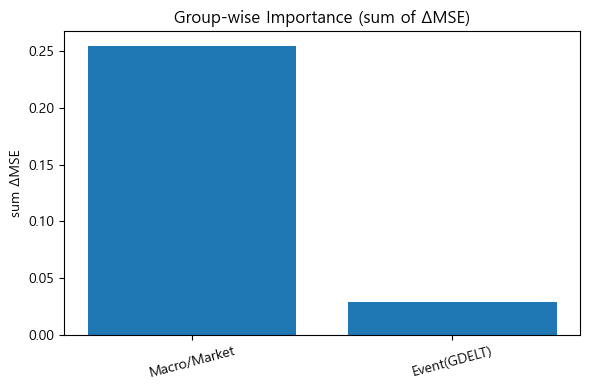

In [18]:
# -------------------------
# 유틸: 케이스/모델로 학습하고, 테스트 시퀀스/스케일러/모델 반환
# -------------------------
def fit_for_importance(case_name="Macro + Event",
                       model_name="LSTM",
                       lookback=20,
                       shift=1,
                       seed=42):
    """
    run_once 내부 로직을 가져와, permutation importance 계산에 필요한 객체를 반환.
    반환:
      model, x_scaler, d_scaler,
      df_case, feats,  # 원본 케이스 DF와 피처 이름 목록
      X_tr_raw, X_te_raw, y_tr_raw, y_te_raw,  # 원시 분할(스케일 전)
      X_te_seq, y_true_te_raw, p_last_te_raw,  # 테스트 시퀀스/정답/직전값
      base_pred, base_mse
    """
    np.random.seed(seed); tf.random.set_seed(seed)

    # 케이스 DF 구성
    df_case = build_case_df(case_name)
    feats = [c for c in df_case.select_dtypes(include=[np.number]).columns if c != TARGET_COL]

    X_all = df_case[feats].values.astype(np.float32)
    y_all = df_case[TARGET_COL].values.astype(np.float32)

    # 분할
    s_tr, s_va, s_te = split_indices(len(df_case), tr_ratio=TRAIN_RATIO, va_ratio=VAL_RATIO)
    X_tr_raw = X_all[s_tr]
    X_te_raw = X_all[s_te]
    y_tr_raw = y_all[s_tr]
    y_te_raw = y_all[s_te]

    # 입력 스케일러 (train 기준)
    x_scaler = RobustScaler()
    X_tr = x_scaler.fit_transform(X_tr_raw)
    X_te = x_scaler.transform(X_te_raw)

    # Δ-타깃 스케일러 (train 기준)
    X_tr_seq_tmp, y_d_tr_raw, _, _ = make_sequences_residual(X_tr, y_tr_raw, lookback, shift=shift)
    if len(X_tr_seq_tmp) == 0:
        raise ValueError("시퀀스 길이 부족(훈련).")
    d_scaler = RobustScaler()
    y_d_tr_sc = d_scaler.fit_transform(y_d_tr_raw.reshape(-1,1)).ravel()

    # 내부 검증 분리(훈련 시퀀스의 10%)
    n_tr_seq = len(X_tr_seq_tmp)
    val_sz = max(1, int(n_tr_seq*0.1))
    X_train, y_train = X_tr_seq_tmp[:-val_sz], y_d_tr_sc[:-val_sz]
    X_valin, y_valin = X_tr_seq_tmp[-val_sz:], y_d_tr_sc[-val_sz:]

    # 테스트 시퀀스 (스케일된 입력, 비스케일 타깃)
    X_te_seq, y_d_te_raw, p_last_te_raw, y_true_te_raw = make_sequences_residual(X_te, y_te_raw, lookback, shift=shift)
    if len(X_te_seq) == 0:
        raise ValueError("시퀀스 길이 부족(테스트).")

    # 모델 학습
    model = build_model(model_name, (lookback, X_train.shape[-1]))
    cbs = [
        EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=0),
    ]
    model.fit(X_train, y_train, validation_data=(X_valin, y_valin),
              epochs=EPOCHS, batch_size=BATCH, callbacks=cbs, verbose=0)

    # 베이스라인 예측/오차
    d_pred_sc = model.predict(X_te_seq, verbose=0).ravel()
    d_pred = d_scaler.inverse_transform(d_pred_sc.reshape(-1,1)).ravel()
    base_pred = p_last_te_raw + d_pred
    base_mse = mean_squared_error(y_true_te_raw, base_pred)

    return (model, x_scaler, d_scaler,
            df_case, feats,
            X_tr_raw, X_te_raw, y_tr_raw, y_te_raw,
            X_te_seq, y_true_te_raw, p_last_te_raw,
            base_pred, base_mse)

# -------------------------
# 유틸: 테스트 입력 한 변수만 섞어서 ΔMSE 계산
# -------------------------
def permute_one_feature_and_score(model, x_scaler, d_scaler,
                                  X_te_raw, y_te_raw,
                                  lookback, shift,
                                  y_true_te_raw, p_last_te_raw,
                                  base_mse,
                                  feat_idx,
                                  n_repeats=5,
                                  rng=None):
    """
    X_te_raw[:, feat_idx]만 무작위로 섞어(다른 피처는 고정),
    동일 스케일링/시퀀스 구성으로 예측 후 MSE 상승(ΔMSE)을 평균.
    """
    if rng is None:
        rng = np.random.RandomState(123)

    deltas = []
    for _ in range(n_repeats):
        Xp_te_raw = X_te_raw.copy()
        rng.shuffle(Xp_te_raw[:, feat_idx])  # 테스트셋 내에서만 섞음

        # 동일 스케일러로 변환 → 동일 시퀀스 구성
        Xp_te = x_scaler.transform(Xp_te_raw)
        Xp_te_seq, y_d_te_raw2, p_last_te_raw2, y_true_te_raw2 = make_sequences_residual(
            Xp_te, y_te_raw, lookback, shift=shift
        )

        # 형태 보호(인덱스가 같지 않으면 여기서 정합성 체크)
        assert np.allclose(y_true_te_raw, y_true_te_raw2), "정합성 오류: y_true 달라짐"
        assert np.allclose(p_last_te_raw, p_last_te_raw2), "정합성 오류: p_last 달라짐"

        d_pred_sc = model.predict(Xp_te_seq, verbose=0).ravel()
        d_pred = d_scaler.inverse_transform(d_pred_sc.reshape(-1,1)).ravel()
        yhat_perm = p_last_te_raw + d_pred

        mse_perm = mean_squared_error(y_true_te_raw, yhat_perm)
        deltas.append(mse_perm - base_mse)

    return float(np.mean(deltas))

# -------------------------
# 그룹 레이블러
# -------------------------
def feature_group_label(col_name):
    if col_name in GDELT_COLS:
        return "Event(GDELT)"
    if col_name.startswith("score_title_"):
        return "Sentiment(Title)"
    if col_name.startswith("score_summary_"):
        return "Sentiment(Summary)"
    if col_name.startswith("score_content_"):
        return "Sentiment(Content)"
    return "Macro/Market"

# -------------------------
# 메인: 퍼뮤테이션 중요도 계산 + 표/그림
# -------------------------
def permutation_importance_pipeline(case_name="Include_GDELT_Summary",
                                    model_name="CNN_LSTM",
                                    lookback=20,
                                    shift=1,
                                    seed=42,
                                    n_repeats=5,
                                    topk=20,
                                    random_state=123):
    (model, x_scaler, d_scaler,
     df_case, feats,
     X_tr_raw, X_te_raw, y_tr_raw, y_te_raw,
     X_te_seq, y_true_te_raw, p_last_te_raw,
     base_pred, base_mse) = fit_for_importance(case_name, model_name, lookback, shift, seed)

    rng = np.random.RandomState(random_state)

    # 각 피처에 대해 ΔMSE 측정
    import_rows = []
    for j, col in enumerate(feats):
        delta = permute_one_feature_and_score(
            model, x_scaler, d_scaler,
            X_te_raw, y_te_raw,
            lookback, shift,
            y_true_te_raw, p_last_te_raw,
            base_mse,
            feat_idx=j,
            n_repeats=n_repeats,
            rng=rng
        )
        import_rows.append((col, delta, feature_group_label(col)))

    imp_df = pd.DataFrame(import_rows, columns=["feature", "importance(ΔMSE)", "group"])
    imp_df = imp_df.sort_values("importance(ΔMSE)", ascending=False).reset_index(drop=True)

    # 그룹 합계
    grp_df = (imp_df.groupby("group", as_index=False)["importance(ΔMSE)"]
              .sum()
              .sort_values("importance(ΔMSE)", ascending=False)
              .reset_index(drop=True))

    # ===== 출력 =====
    print("\n=== Primary Setting ===")
    print(f"Case={case_name}, Model={model_name}, lookback={lookback}, shift={shift}, seed={seed}")
    print(f"Baseline Test MSE={base_mse:.3f}, RMSE={np.sqrt(base_mse):.3f}")

    print("\n=== Permutation Importance (ΔMSE) — Top {} ===".format(topk))
    display(imp_df.head(topk))

    print("\n=== Group-wise Importance (sum of ΔMSE) ===")
    display(grp_df)

    # ===== 시각화 =====
    # Top-K Features
    top = imp_df.head(topk).iloc[::-1]  # 바차트 위에서 아래로 정렬
    plt.figure(figsize=(8, max(4, 0.4*len(top))))
    plt.barh(top["feature"], top["importance(ΔMSE)"])
    plt.title(f"Permutation Importance (Top {topk})\n[{case_name} | {model_name} | lookback={lookback}, shift={shift}]")
    plt.xlabel("ΔMSE (higher = more important)")
    plt.tight_layout()
    plt.show()

    # Group-wise bar
    plt.figure(figsize=(6,4))
    plt.bar(grp_df["group"], grp_df["importance(ΔMSE)"])
    plt.title("Group-wise Importance (sum of ΔMSE)")
    plt.ylabel("sum ΔMSE")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

    return imp_df, grp_df, dict(base_mse=base_mse)

# =========================
# 실행 예시 (베스트 설정 기반)
# =========================
best_case = "Macro + Event"   
best_model = "LSTM"
best_lb = 20
best_shift = 1
best_seed = 42

imp_df, grp_df, base_info = permutation_importance_pipeline(
    case_name=best_case,
    model_name=best_model,
    lookback=best_lb,
    shift=best_shift,
    seed=best_seed,
    n_repeats=5,     # 시간/정확도 균형.
    topk=20,
    random_state=123
)

# CSV 저장
imp_df.to_csv("perm_importance_features.csv", index=False, encoding="utf-8-sig")
grp_df.to_csv("perm_importance_groups.csv", index=False, encoding="utf-8-sig")

# 시각화

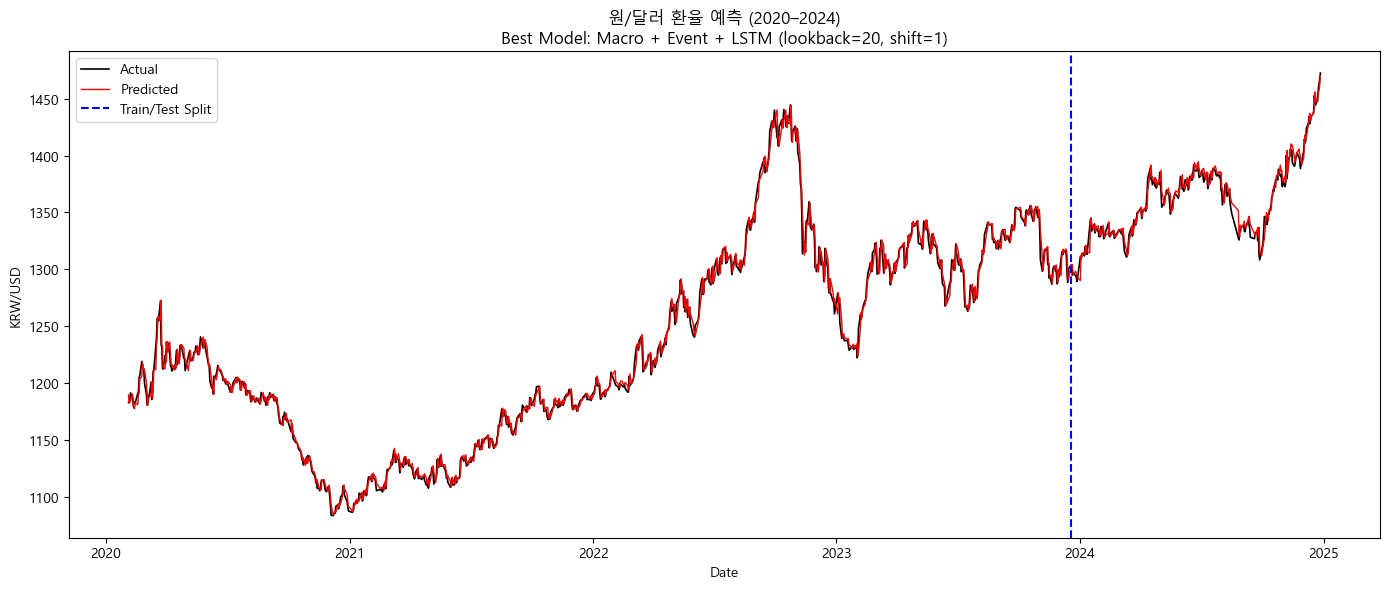

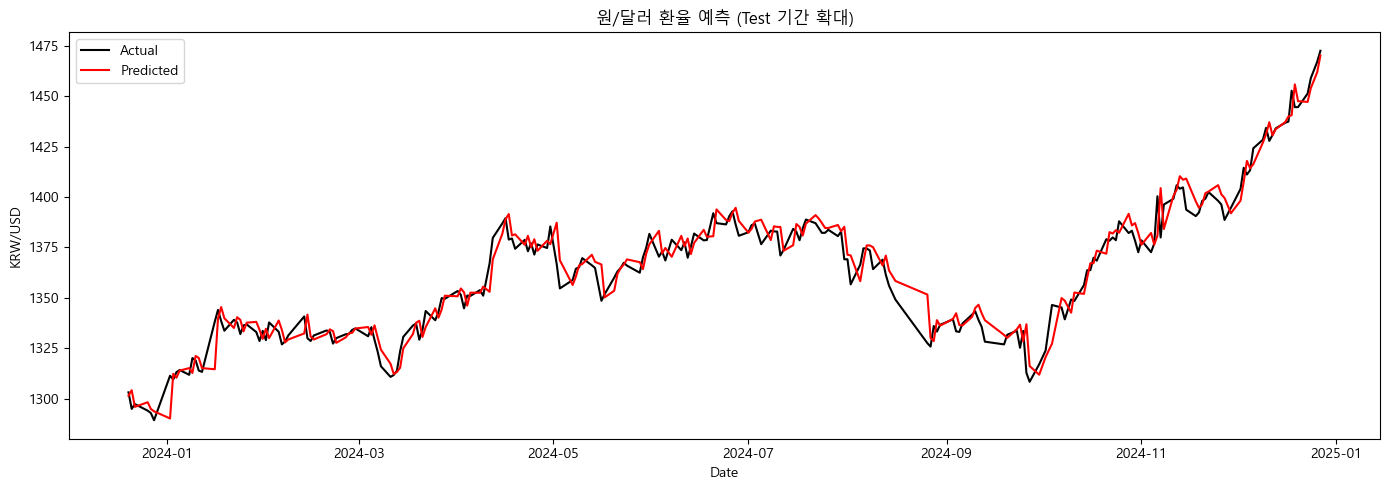

Test Performance: MSE=52.379, RMSE=7.237, MAE=5.482, MAPE=0.403%


(array(['2020-02-04T00:00:00.000000000', '2020-02-05T00:00:00.000000000',
        '2020-02-06T00:00:00.000000000', ...,
        '2024-12-24T00:00:00.000000000', '2024-12-26T00:00:00.000000000',
        '2024-12-27T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([1182.9 , 1183.4 , 1185.28, ..., 1458.93, 1467.08, 1472.5 ],
       dtype=float32),
 array([1189.5496, 1182.4838, 1182.8   , ..., 1453.9893, 1461.8776,
        1470.1638], dtype=float32))

In [21]:
def refit_and_plot_full(best_case="Macro + Event",
                        best_model="LSTM",
                        lookback=20,
                        shift=1,
                        seed=42):

    np.random.seed(seed); tf.random.set_seed(seed)

    # 케이스 데이터 준비
    df_case = build_case_df(best_case)
    feats = [c for c in df_case.select_dtypes(include=[np.number]).columns if c != TARGET_COL]

    X_all = df_case[feats].values.astype(np.float32)
    y_all = df_case[TARGET_COL].values.astype(np.float32)
    # 날짜는 실제 날짜 컬럼 사용
    dates_all = df_case[DATE_COL].to_numpy()

    # split
    s_tr, s_va, s_te = split_indices(len(df_case), tr_ratio=TRAIN_RATIO, va_ratio=VAL_RATIO)

    # 스케일링
    x_scaler = RobustScaler()
    X_tr = x_scaler.fit_transform(X_all[s_tr])
    X_all_scaled = x_scaler.transform(X_all)

    d_scaler = RobustScaler()
    X_tr_seq_tmp, y_d_tr_raw, _, _ = make_sequences_residual(
        X_tr, y_all[s_tr], lookback, shift=shift
    )
    y_d_tr_sc = d_scaler.fit_transform(y_d_tr_raw.reshape(-1,1)).ravel()

    # 내부 train/val 분리
    n_tr_seq = len(X_tr_seq_tmp)
    val_sz = max(1, int(n_tr_seq*0.1))
    X_train, y_train = X_tr_seq_tmp[:-val_sz], y_d_tr_sc[:-val_sz]
    X_val, y_val = X_tr_seq_tmp[-val_sz:], y_d_tr_sc[-val_sz:]

    # 모델 빌드 & 학습
    model = build_model(best_model, (lookback, X_train.shape[-1]))
    cbs = [
        EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=0),
    ]
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=EPOCHS, batch_size=BATCH, callbacks=cbs, verbose=0)

    # ===== 전체 구간 예측 =====
    X_all_seq, y_d_all_raw, p_last_all_raw, y_true_all_raw = make_sequences_residual(
        X_all_scaled, y_all, lookback, shift=shift
    )
    d_pred_sc = model.predict(X_all_seq, verbose=0).ravel()
    d_pred = d_scaler.inverse_transform(d_pred_sc.reshape(-1,1)).ravel()
    yhat_all = p_last_all_raw + d_pred

    # 실제/예측 길이 맞추기 (dates는 lookback+shift-1부터 시작)
    dates_plot = dates_all[lookback + shift - 1:]
    y_true_plot = y_true_all_raw
    yhat_plot = yhat_all

    # 안전하게 길이 통일 (오프바이원 방지)
    L = min(len(dates_plot), len(y_true_plot), len(yhat_plot))
    dates_plot = dates_plot[:L]
    y_true_plot = y_true_plot[:L]
    yhat_plot = yhat_plot[:L]

    # Train/Test split 라인 위치 (dates 기준으로도 보정)
    split_idx = s_tr.stop - 1  # train 마지막 원시 인덱스
    split_date_idx = split_idx - (lookback + shift - 1)
    if 0 <= split_date_idx < len(dates_plot):
        split_date_val = dates_plot[split_date_idx]
    else:
        split_date_val = None

    # ===== 시각화 =====
    plt.figure(figsize=(14,6))
    plt.plot(dates_plot, y_true_plot, label="Actual", color="black", linewidth=1.2)
    plt.plot(dates_plot, yhat_plot, label="Predicted", color="red", linewidth=1.0)
    if split_date_val is not None:
        plt.axvline(split_date_val, color="blue", linestyle="--", label="Train/Test Split")
    plt.title(f"원/달러 환율 예측 (2020–2024)\nBest Model: {best_case} + {best_model} (lookback={lookback}, shift={shift})")
    plt.xlabel("Date"); plt.ylabel("KRW/USD")
    plt.legend(); plt.tight_layout(); plt.show()

    # ===== 확대 (Test 기간만) =====
    # test 시작도 dates 기준으로 보정
    test_start_raw = s_te.start  # 원시 인덱스
    test_start_seq = test_start_raw - (lookback + shift - 1)
    test_start_seq = max(0, test_start_seq)
    plt.figure(figsize=(14,5))
    plt.plot(dates_plot[test_start_seq:], y_true_plot[test_start_seq:], label="Actual", color="black")
    plt.plot(dates_plot[test_start_seq:], yhat_plot[test_start_seq:], label="Predicted", color="red")
    plt.title("원/달러 환율 예측 (Test 기간 확대)")
    plt.xlabel("Date"); plt.ylabel("KRW/USD")
    plt.legend(); plt.tight_layout(); plt.show()

    # 메트릭 계산 (test 구간만)
    y_true_test = y_true_plot[test_start_seq:]
    y_hat_test  = yhat_plot[test_start_seq:]
    mse = mean_squared_error(y_true_test, y_hat_test)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_test, y_hat_test)
    mape = np.mean(np.abs((y_true_test - y_hat_test) / y_true_test)) * 100
    print(f"Test Performance: MSE={mse:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}, MAPE={mape:.3f}%")

    return dates_plot, y_true_plot, yhat_plot

refit_and_plot_full(best_case="Macro + Event",
                        best_model="LSTM",
                        lookback=20,
                        shift=1,
                        seed=42)

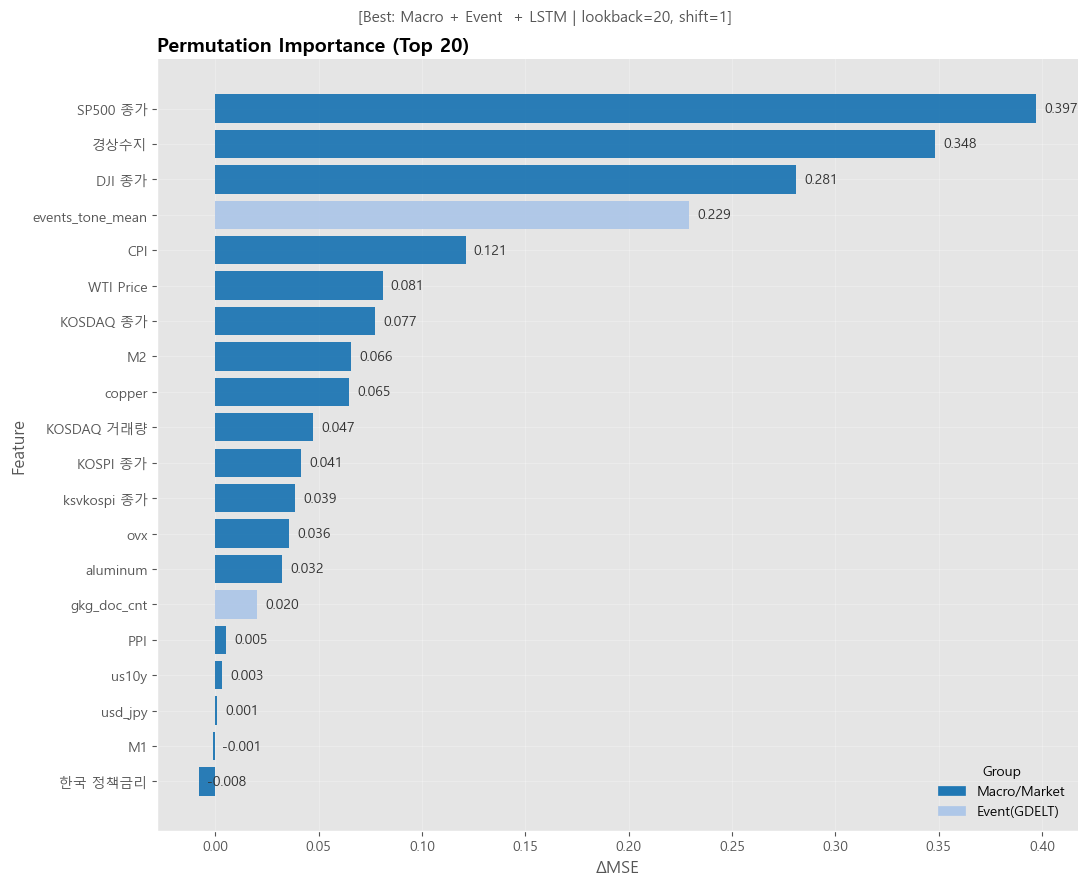

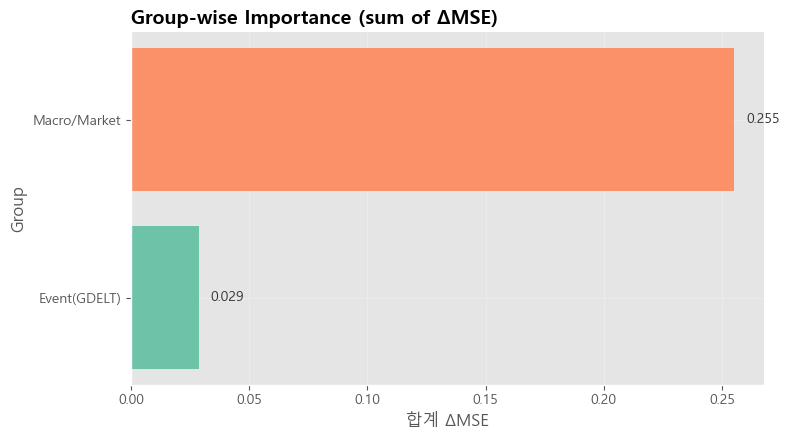

In [24]:
def _nice_axes(ax):
    ax.grid(True, alpha=0.25, linewidth=0.8)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

def plot_perm_importance_topk(imp_df, topk=20, title="Permutation Importance (Top 20)", subtitle=None):
    """
    imp_df: columns = ["feature", "importance(ΔMSE)", "group"]
    """
    # _set_korean_font()
    plt.style.use("ggplot")  # 기본 톤 잡기

    top = imp_df.sort_values("importance(ΔMSE)", ascending=False).head(topk).iloc[::-1]
    values = top["importance(ΔMSE)"].values
    labels = top["feature"].values
    groups = top["group"].values

    # 그룹별 색상 자동 할당
    unique_groups = list(dict.fromkeys(groups))  # 순서 보존
    cmap = mpl.colormaps.get_cmap("tab20")
    color_map = {g: cmap(i % cmap.N) for i, g in enumerate(unique_groups)}
    colors = [color_map[g] for g in groups]

    fig, ax = plt.subplots(figsize=(11, max(5, 0.45*len(top))))
    bars = ax.barh(labels, values, color=colors, edgecolor="none", alpha=0.95)
    _nice_axes(ax)

    # 값 라벨 (막대 끝)
    for b, v in zip(bars, values):
        ax.text(v + (values.max()*0.01), b.get_y() + b.get_height()/2,
                f"{v:.3f}", va="center", ha="left", fontsize=10, color="#333333")

    # 범례 (그룹)
    handles = [mpl.patches.Patch(color=color_map[g], label=g) for g in unique_groups]
    leg = ax.legend(handles=handles, title="Group", frameon=False, ncol=1, loc="lower right")

    ax.set_xlabel("ΔMSE")
    ax.set_ylabel("Feature")
    ax.set_title(title, loc="left", pad=6, fontsize=14, fontweight="bold")
    if subtitle:
        fig.suptitle(subtitle, y=0.98, fontsize=11, color="#555555")
    fig.tight_layout()
    plt.show()

def plot_group_importance(grp_df, title="Group-wise Importance (sum of ΔMSE)"):
    """
    grp_df: columns = ["group", "importance(ΔMSE)"]
    """
    # _set_korean_font()
    plt.style.use("ggplot")

    df = grp_df.sort_values("importance(ΔMSE)", ascending=True)
    values = df["importance(ΔMSE)"].values
    labels = df["group"].values

    cmap = mpl.colormaps.get_cmap("Set2")
    colors = [cmap(i % cmap.N) for i in range(len(df))]

    fig, ax = plt.subplots(figsize=(8, 4.5))
    bars = ax.barh(labels, values, color=colors, edgecolor="none", alpha=0.95)
    _nice_axes(ax)

    for b, v in zip(bars, values):
        ax.text(v + (values.max()*0.02 if values.max()>0 else 0.01),
                b.get_y() + b.get_height()/2,
                f"{v:.3f}", va="center", ha="left", fontsize=10, color="#333333")

    ax.set_xlabel("합계 ΔMSE")
    ax.set_ylabel("Group")
    ax.set_title(title, loc="left", pad=6, fontsize=14, fontweight="bold")
    fig.tight_layout()
    plt.show()

# ==========
plot_perm_importance_topk(imp_df, topk=20,
    title="Permutation Importance (Top 20)",
    subtitle="[Best: Macro + Event  + LSTM | lookback=20, shift=1]")
plot_group_importance(grp_df, title="Group-wise Importance (sum of ΔMSE)")